First we load and sort the data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import h5py
import numpy as np
import os

/Users/mattzhang/py2_kernel/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# load data
data = h5py.File("../../../Data/EC2_blocks_1_8_9_15_76_89_105_CV_HG_align_window_-0.5_to_0.79_file_nobaseline.h5")
X_data = data['Xhigh gamma'][:]
y_data = data['y'][:] # phoneme label

In [3]:
# preprocessing
X_data = np.divide(X_data, np.amax(X_data)) # normalize ECoG signal

In [4]:
# flatten each event into a 22188-dimensional vector. Then take all 2572 events and make a 2572x22188 matrix.
X_data = X_data.reshape(X_data.shape[0], -1)

We use SVD to keep 50% of the data.

In [5]:
import pymf
import seaborn as sb

In [6]:
keep_data = 0.5

In [7]:
SVD = pymf.SVD(X_data)
SVD.factorize()

In [8]:
normalized_diagonal = SVD.S.diagonal()/sum(SVD.S.diagonal())
sum_data = 0
n_kept_dimensions = 0
for i in range(len(normalized_diagonal)):
    sum_data += normalized_diagonal[i]
    if sum_data > keep_data:
        n_kept_dimensions = i
        break

In [9]:
n_kept_dimensions

542

In [10]:
X_data_reduced_SVD = SVD.U[:,:n_kept_dimensions].dot(SVD.S[:n_kept_dimensions,:n_kept_dimensions]).dot(SVD.V[:n_kept_dimensions,:])

In [11]:
# reshape data back into 2572x86x258 matrix.
X_data = X_data.reshape(X_data.shape[0], 86, 258)
X_data_reduced_SVD = X_data_reduced_SVD.reshape(X_data.shape[0], 86, 258)

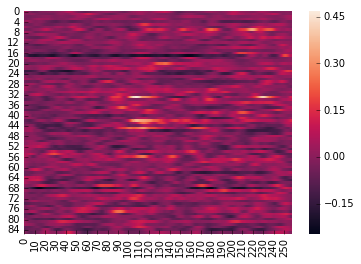

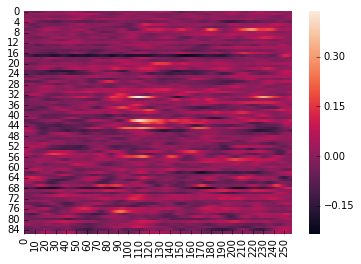

In [12]:
sb.heatmap(X_data[0])
plt.show()
sb.heatmap(X_data_reduced_SVD[0])
plt.show()

And now the same thing with CUR. Since CUR is less accurate than SVD, let's keep 600 columns rather than 542 (where each column corresponds to one "pixel" in the channel-time plot).

In [13]:
# flatten each event into a 22188-dimensional vector. Then take all 2572 events and make a 2572x22188 matrix.
X_data = X_data.reshape(X_data.shape[0], -1)

In [14]:
# crank = number of kept columns, rrank = number of kept rows
# this doesn't actually work right. crank doesn't do anything, and rrank is just the normal rank
CUR = pymf.CUR(X_data, rrank=600)
CUR.factorize()

In [15]:
CUR.U.shape

(2572, 600)

In [16]:
from __future__ import print_function
keptCols = []
for i in range(len(CUR.U[0])):
    if i%10==0: print('.', end='')
    for j in range(len(X_data[0])):
        if np.array_equal(CUR.U[:,i], X_data[:,j]):
            keptCols.append(j)

............................................................

In [17]:
len(keptCols)

600

In [18]:
X_data_reduced_CUR = CUR.U.dot(CUR.S).dot(CUR.V)

In [19]:
# reshape data back into 2572x86x258 matrix.
X_data_reduced_cols_CUR = np.zeros(X_data.shape)
X_data_reduced_cols_CUR[:,keptCols] = X_data[:,keptCols]
X_data = X_data.reshape(X_data.shape[0], 86, 258)
X_data_reduced_CUR = X_data_reduced_CUR.reshape(X_data.shape[0], 86, 258)
X_data_reduced_cols_CUR = X_data_reduced_cols_CUR.reshape(X_data.shape[0], 86, 258)

Now for a single event we look at the original channel-time info, the reduced info after CUR, and only the pixels where data was kept.

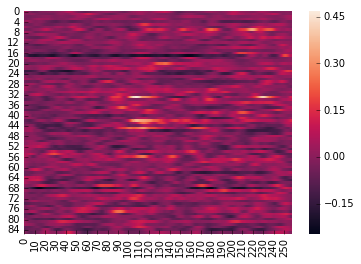

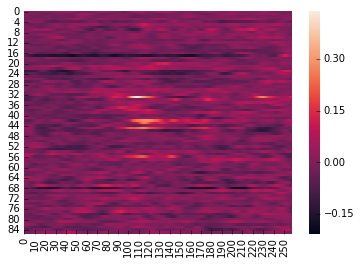

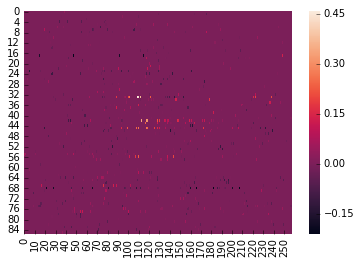

In [20]:
sb.heatmap(X_data[0])
plt.show()
sb.heatmap(X_data_reduced_CUR[0])
plt.show()
sb.heatmap(X_data_reduced_cols_CUR[0])
plt.show()

Let's see the averaged original data and kept pixels for each phoneme.

In [21]:
# sort by phonemes
sort_order = y_data.argsort() # sort by phonemes
X_data = X_data[sort_order]
y_data = y_data[sort_order]
X_data_reduced_cols_CUR = X_data_reduced_cols_CUR[sort_order]

In [22]:
# calculate averages for each phoneme
X_averages = []
X_reduced_cols_CUR_averages = []
for phoneme in range(max(y_data)+1):
    indices = [y_data == phoneme]
    X_averages.append(np.mean(X_data[indices], axis=0))
    X_reduced_cols_CUR_averages.append(np.mean(X_data_reduced_cols_CUR[indices], axis=0))

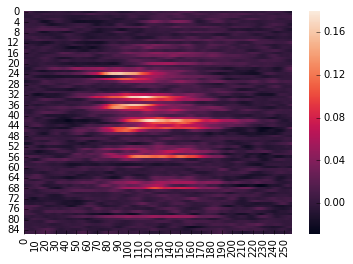

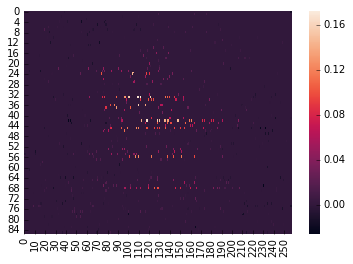

In [25]:
import ipywidgets as widgets
def plotAverage(i):
    sb.heatmap(X_averages[i])
    plt.show()
    sb.heatmap(X_reduced_cols_CUR_averages[i])
    plt.show()
widgets.interact(plotAverage, i=(0,86))